In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Image Segmentation

In [5]:
from sklearn.datasets import load_sample_images

dataset = load_sample_images()
Img = dataset.images[1]
Img.shape

(427, 640, 3)

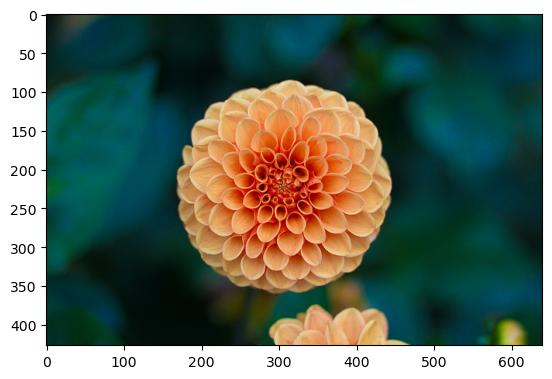

In [6]:
img = Img/255
plt.imshow(img)
plt.show()

In [7]:
x = img.reshape(-1, 3)
x.shape

(273280, 3)

In [8]:
#KMeans

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=1, n_init='auto').fit(x)

In [14]:
kmeans.cluster_centers_

array([[0.0252104 , 0.21208228, 0.19545371],
       [0.82540994, 0.53242036, 0.31307987]])

In [15]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [16]:
segImg = kmeans.cluster_centers_[kmeans.labels_]
segImg

array([[0.0252104 , 0.21208228, 0.19545371],
       [0.0252104 , 0.21208228, 0.19545371],
       [0.0252104 , 0.21208228, 0.19545371],
       ...,
       [0.0252104 , 0.21208228, 0.19545371],
       [0.0252104 , 0.21208228, 0.19545371],
       [0.0252104 , 0.21208228, 0.19545371]])

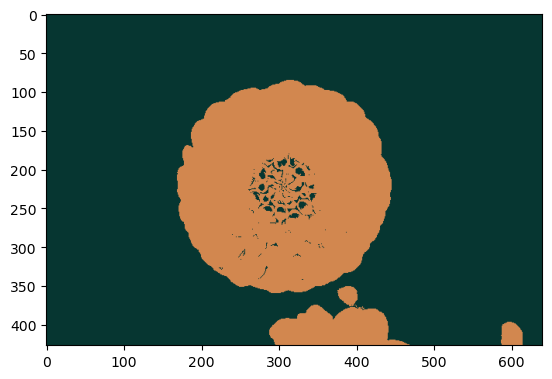

In [18]:
segImg = segImg.reshape(img.shape)
plt.imshow(segImg)
plt.show()

In [19]:
#Preprocessing

In [20]:
from sklearn.datasets import load_digits

x, y = load_digits(return_X_y=True)
x.shape, y.shape

((1797, 64), (1797,))

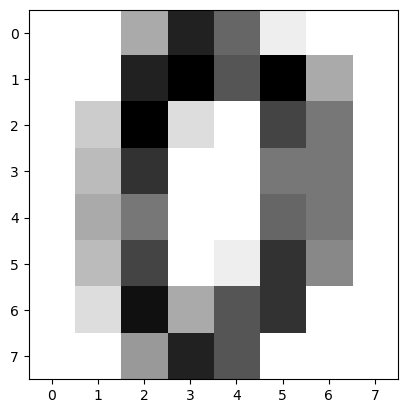

In [21]:
i=0
xi = x[i].reshape(8, 8)
plt.imshow(xi, cmap='binary')
plt.show()

In [22]:
y[i]

0

In [23]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(x, y, stratify=y, random_state=1)

In [24]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(multi_class='ovr', max_iter=5000, random_state=1)
logReg.fit(xTrain, yTrain)
logReg.score(xTest, yTest)

0.9577777777777777

In [25]:
#LogisticRegression with KMeans

In [26]:
kmeans = KMeans(n_clusters=40, random_state=1)
xTrainDist = kmeans.fit_transform(xTrain, yTrain)
xTrainDist.shape

/Users/otis/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(1347, 40)

In [28]:
logReg = LogisticRegression(multi_class='ovr',max_iter=5000, random_state=1)
logReg.fit(xTrainDist, yTrain)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=1)

In [29]:
xTestDist = kmeans.transform(xTest)
logReg.score(xTestDist, yTest)

0.9688888888888889

In [36]:
#LogisticRegression with KMeans(Pipeline)
from sklearn.pipeline import Pipeline

pip = Pipeline([
    ('kmeans', KMeans(n_clusters=40, random_state=1, n_init='auto')),
    ('logReg', LogisticRegression(multi_class='ovr', max_iter=5000, random_state=1))
])
pip.fit(xTrain, yTrain)
pip.score(xTest, yTest)

0.9688888888888889

In [32]:
#LogisticRegression with KMeans (Grid Search)

In [38]:
from sklearn.model_selection import GridSearchCV

paramGrid = dict(kmeans__n_clusters=np.linspace(20, 100, 5).astype(np.int64))
gridClf = GridSearchCV(pip, paramGrid, cv=3, verbose=2)
gridClf.fit(xTrain, yTrain)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ..............................kmeans__n_clusters=20; total time=   0.8s
[CV] END ..............................kmeans__n_clusters=20; total time=   0.8s
[CV] END ..............................kmeans__n_clusters=20; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=40; total time=   1.4s
[CV] END ..............................kmeans__n_clusters=40; total time=   1.0s
[CV] END ..............................kmeans__n_clusters=40; total time=   1.1s
[CV] END ..............................kmeans__n_clusters=60; total time=   1.8s
[CV] END ..............................kmeans__n_clusters=60; total time=   1.8s
[CV] END ..............................kmeans__n_clusters=60; total time=   1.3s
[CV] END ..............................kmeans__n_clusters=80; total time=   1.4s
[CV] END ..............................kmeans__n_clusters=80; total time=   1.5s
[CV] END ..............................kmeans__n_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=40, n_init='auto',
                                               random_state=1)),
                                       ('logReg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=1))]),
             param_grid={'kmeans__n_clusters': array([ 20,  40,  60,  80, 100])},
             verbose=2)

In [44]:
gridClf.best_params_

{'kmeans__n_clusters': 100}

In [43]:
rlt = gridClf.cv_results_
for mean_score, params in zip(rlt['mean_test_score'], rlt['params']):
    print(mean_score, params)

0.9576837416481069 {'kmeans__n_clusters': 20}
0.9673348181143281 {'kmeans__n_clusters': 40}
0.9740163325909429 {'kmeans__n_clusters': 60}
0.9740163325909429 {'kmeans__n_clusters': 80}
0.9755011135857461 {'kmeans__n_clusters': 100}


In [46]:
gridClf.best_estimator_.score(xTest, yTest)

0.9733333333333334

In [47]:
#Semi-supervised Learning

In [49]:
k = 50

kmeans = KMeans(n_clusters=k, random_state=1, n_init='auto')
xDist = kmeans.fit_transform(xTrain)

In [53]:
repInd = np.argmin(xDist, axis=0)
xTrainRep = xTrain[repInd]

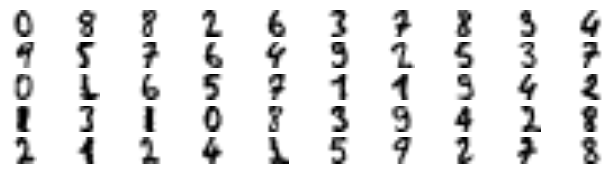

In [56]:
plt.figure(figsize=(8, 2))
for idx, xi in enumerate(xTrainRep):
    plt.subplot (k//10, 10, idx+1)
    plt.imshow(xi.reshape(8,8), cmap='binary', interpolation='bilinear')
    plt.axis('off')
plt.show()

In [59]:
#人工標籤(代表性樣本)

In [61]:
yRep = np.array([
    9, 2, 0, 4, 7, 5, 1, 6, 3, 1,
    2, 3, 1, 6, 8, 5, 2, 9, 4, 4,
    7, 4, 8, 3, 6, 9, 5, 7, 7, 2,
    2, 1, 4, 7, 3, 0, 9, 4, 7, 3,
    1, 1, 3, 1, 0, 2, 8, 9, 8, 4
])

In [62]:
#自動標籤(所有樣本)

In [63]:
yTrainPropagated = np.empty(len(xTrain), dtype=np.int32)
for i in range(k):
    yTrainPropagated[kmeans.labels_==i] = yRep[i]

In [64]:
xTrain.shape, yTrainPropagated.shape

((1347, 64), (1347,))

In [65]:
#訓練分類模型

In [66]:
#Train:LogisticRegression

In [67]:
logReg = LogisticRegression(multi_class='ovr', max_iter=5000, random_state=1)
logReg.fit(xTrain, yTrainPropagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=1)

In [70]:
logReg.score(xTest, yTest)

0.09111111111111111